Trying to update the Webscraping Indeed Notebook to Python 3

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
# API Calls
import requests
# Parse HTML
import bs4
# Handle Dataframes (excel data)
import pandas as pd
pd.set_option('display.max_colwidth', -1)
# Plotting library
import matplotlib.pyplot as plt
# Math functions lib
import numpy as np

## Fetching and Cleaning Indeed Search Data

In [3]:
from indeed_scraper import search_indeed, clean_data, save_data, posting_scraper
from utils import save_data

In [4]:
# Fetch Page Information for Indeed Search
# TODO: Add url encoding so you don't have to do it manually here.
query = "machine+learning"
cities = [
    "New+York%2C+NY",
    "San+Jose%2C+CA",
    "Austin%2C+TX",
    "San+Francisco%2C+CA",
    "Phoenix%2C+AZ",
    "Greenwich%2C+CT"
]
max_results_per_city = 100
null_value = "NA"

df = search_indeed(query, cities, max_results_per_city, null_value)
df = clean_data(df)
filename = save_data(df, query, path='./indeed_searches/')
print(filename)

./indeed_searches/machine+learning-2018_11_28-000756


## Getting Data Per Posting Page (WIP)

In [5]:
# Getting one posting worth of data
# url = data.loc[:, 'url'].values[88]
# print(url)
# html = requests.get(url).text
# soups = bs4.BeautifulSoup(html, "html.parser")
# # Print out job description as one srting
# main_content = soups.find('div', {'class': "jobsearch-JobComponent icl-u-xs-mt--sm jobsearch-JobComponent-bottomDivider"})
# job_description = soups.find('div', {'class': "jobsearch-JobComponent-description icl-u-xs-mt--md"})
# ' '.join([x.get_text(strip=True) for x in job_description.find_all('li')])

In [6]:
## Getting Data Per Posting Page (WIP)
data = pd.read_csv(f"{filename}.csv", index_col=0)
desc_dataframe = posting_scraper(data, filename, drop_old_postings=True, li_search=False)
data['desc'] = desc_dataframe['desc']
data.dropna(subset = ['desc'], inplace=True)
data.reset_index(drop=True, inplace=True)
data.to_csv(f'{filename}.csv', sep=',', encoding='utf-8')

## Count Vectorizer on File
Seeing most popular words in job posting.

In [7]:
# filename = "machine+learning-2018_11_24-185749"
job_info = pd.read_csv(f'{filename}.csv', index_col=0)

In [8]:
descriptions = []
for txtfile in job_info['desc']:
    with open(txtfile, 'r', encoding='utf-8') as the_file:
        descriptions.append(the_file.read().lower())

In [9]:
%autoreload 2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from more_stop_words import more_stop_words
custom_stop_words = ENGLISH_STOP_WORDS.union(more_stop_words)

In [10]:
# print(descriptions)
vectorizer = CountVectorizer(stop_words=custom_stop_words)
X = vectorizer.fit_transform(descriptions)

# Summing words along columns to find total amount of occurences per word.
feature_names = vectorizer.get_feature_names()
sum_words = X.sum(axis=0).tolist()[0]
words_freq = zip(feature_names, sum_words)
words_freq =sorted(words_freq, key = lambda x: -x[1])

In [11]:
# final_map = [word for word in words_freq if word[1] > 0]
print(words_freq[:20])
# final_map[:50]

[('time', 259), ('python', 256), ('deep', 254), ('analytics', 250), ('ai', 185), ('processing', 174), ('ml', 128), ('big', 124), ('natural', 120), ('training', 120), ('education', 118), ('statistical', 108), ('statistics', 106), ('artificial', 105), ('java', 104), ('advanced', 101), ('modeling', 98), ('sales', 98), ('sql', 98), ('platforms', 94)]


## TD-IDF Transformer and Clustering

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tf = transformer.fit_transform(X)
# print(X_tf.todense())
X_tf.shape[0]//18

16

In [21]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

clusters = 12
# Using 8 buckets, should use differnt amount.
km = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1)
km.fit(X_tf)

# # k means determine k
# import time
# # 100-150 -> .70-.58
# distortions = []
# K = range(1, X_tf.shape[0])
# for k in K:
#     start = time.time()
#     X_tf_arr = X_tf.toarray()
#     kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=100)
#     kmeanModel.fit(X_tf_arr)
#     distortions.append(sum(np.min(cdist(X_tf_arr, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_tf_arr.shape[0])
#     end = time.time()
#     print(k, end - start)
# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = feature_names
for i in range(len(order_centroids)):
    print(f"Cluster {i}-{np.where(km.labels_ == i)[0].shape[0]}:\t" , end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0-10:	 insurance property analytics shipwell riskmatch planet cardinal cannopy lemonade buildinglink
Cluster 1-20:	 training honor analytics time boarding consultant consistently facilitation unity sessions
Cluster 2-46:	 natural processing artificial ca ai storage youtube speech recognition deep
Cluster 3-43:	 sales frameworks ml python analytics tensorflow network deep big york
Cluster 4-20:	 health sensors lidar sensor robotics time studies driving autonomous statistical
Cluster 5-35:	 aws python applied cross ml statistics spark statistical scientists optimization
Cluster 6-22:	 security bank emergent education financial bachelor plans yield analytics agile
Cluster 7-34:	 amd inference ai ml nlp deep cognitivescale model takes gpu
Cluster 8-36:	 apple education additional deep internship analytics python intern summer analytic
Cluster 9-14:	 computational clinical disease w2o genetic paige gene cancer genetics seq
Cluster 10-6:	 claims insurance car metromile auto mile outg

In [26]:
def cluster_index(values, search_val):
     return np.where(values == search_val)[0]
filtered_data = data.loc[ cluster_index(km.labels_, 4), ['company', 'job_title', 'url', 'location']]
# filtered_data = filtered_data[filtered_data['location'].str.contains('New|CT')]
# filtered_data.to_csv('data_engineering.csv', sep=',', encoding='utf-8')
filtered_data

# for i in range(len(order_centroids)):
#     filtered_data = data.loc[ cluster_index(km.labels_, i), ['company', 'job_title', 'url', 'location']]
#     filtered_data['company'] = filtered_data['company'].str.strip()
#     filtered_data.to_csv(f'{filename}/cluster_{i}_k_20.csv', sep=',', encoding='utf-8', index=False)



,company,job_title,url,location
15,PulsePoint,Machine Learning Engineer,https://www.indeed.com/viewjob?jk=14a06809196dc969,New+York%2C+NY
17,Pager,Machine Learning Engineer,https://www.indeed.com/viewjob?jk=fe8f13c8ac5e059f,New+York%2C+NY
38,Vettery,Talent Executive,https://www.indeed.com/viewjob?jk=589ae69563cca553,New+York%2C+NY
53,Apple,Biomedical Data Scientist - Health Technologies,https://www.indeed.com/viewjob?jk=af96206c6d3a082c,San+Jose%2C+CA
62,Apple,Data Scientist,https://www.indeed.com/viewjob?jk=3203ff51d400bfe3,San+Jose%2C+CA
66,Waymo,"Intern, Research, Computer Vision & Machine Learning",https://www.indeed.com/viewjob?jk=2fe05bf0913ccb7b,San+Jose%2C+CA
75,Akorbi,Machine Learning Research Engineer,https://www.indeed.com/viewjob?jk=868728e276170c4e,San+Jose%2C+CA
88,JP Morgan Chase,Asset & Wealth Management – Intelligent Digital Solutions –...,https://www.indeed.com/viewjob?jk=1cf88d4f366c8b59,San+Jose%2C+CA
92,"Innovusion, Inc.",Machine Learning Software Engineer,https://www.indeed.com/viewjob?jk=6350d3773a2c4fd9,San+Jose%2C+CA
130,Code Pilot,Data Scientist,https://www.indeed.com/viewjob?jk=d96cbc155bf91032,Austin%2C+TX


Next Steps are to sort these words into categories (job, technologies, companies)

# Word2Vec

In [46]:
# !powershell -command "&{sudo pip3 install nltk}"
from gensim.models import word2vec
from nltk import word_tokenize

# TODO: Remove Stop Words Manually
# TODO: Preprocess Strings with Gensim
# we need to pass splitted sentences to the model
tokenized_sentences = [word_tokenize(sentence) for sentence in descriptions]

model = word2vec.Word2Vec(tokenized_sentences, min_count=1)

In [57]:
Xwv = model.wv[model.wv.vocab]
model.wv.most_similar(positive="nlp")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('libraries', 0.99693363904953),
 ('deploying', 0.9954078793525696),
 ('big', 0.9952630400657654),
 ('frameworks', 0.9944208264350891),
 ('knowledge', 0.9938005208969116),
 ('modeling', 0.9932716488838196),
 ('fundamentals', 0.9932254552841187),
 ('systems', 0.9930922985076904),
 ('understanding', 0.9925870895385742),
 ('analysis', 0.9925137758255005)]

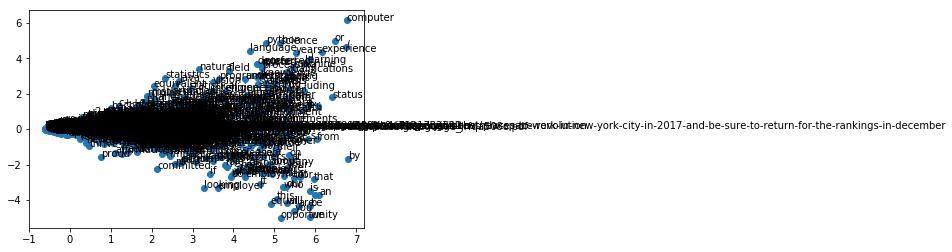

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
result = pca.fit_transform(Xwv)


plt.scatter(result[:, 0], result[:, 1])

words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()